In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import math
from skimage import feature

# Blob detection

### Introduction
We first import a test picture to be used in the exercises.

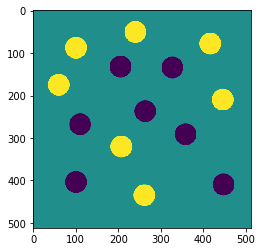

In [58]:
img = cv2.imread('EX_2_data/test_blob_uniform.png.', cv2.IMREAD_GRAYSCALE)
img = img.astype(float)
plt.imshow(img)
plt.show()

### Task 1

The density of a Gaussian with mean equal to zero, and variance $t$ can be written as:
\begin{equation}
g(x) = \frac{1}{\sqrt{2\pi t}} e^{-\frac{x^2}{2t}}
\end{equation}
The secondderivative of which can be computed to be:
$$\frac{d^2}{dx^2}g =
\frac{-1}{t\sqrt{2\pi t}}e^{\frac{-x^2}{2t}} + \frac{x^2}{t^2\sqrt{2\pi t}}e^{\frac{-x^2}{2t}} =
\left(\frac{x^2}{t^2}-\frac{1}{t}\right)\frac{1}{\sqrt{2\pi t}}e^{\frac{-x^2}{2t}} = \left(\frac{x^2}{t^2}-\frac{1}{t}\right)\cdot g$$

### Task 2
A function is implemented to compute a filter kernel og $g$, and $\frac{d^2}{dx^2}g$ given $t$.

The width of the kernel is set to be (at least) $3\cdot \sqrt{t}$. That is since approx. 99.7 % of the probability density is within 3 std. deviations of the mean in a normal distribution.

In [59]:
def gaussian(t=3, s=3):
    x = np.arange(-np.ceil(s*np.sqrt(t)), np.ceil((s*np.sqrt(t)))+1)
    filt = 1.0/np.sqrt(t*2.0*np.pi)*np.exp(-(x**2.0)/(2.0*t))
    return np.array([filt])

def fst_deriv_gaussian(t=3, s=3):
    x = np.arange(-np.ceil(s*np.sqrt(t)), np.ceil((s*np.sqrt(t)))+1)
    filt = (-x/t)*gaussian(t, s=s)
    return np.array([filt])

def scd_deriv_gaussian(t=3, s=3):
    x = np.arange(-np.ceil(s*np.sqrt(t)), np.ceil((s*np.sqrt(t)))+1)
    filt = ((x**2.0)/(t**2.0) - 1/t)*gaussian(t, s=s)
    return filt

In [60]:
t = 25**2/2 # the variance of the filter
s = 3 # multiplier for finding kernel width
scd_gauss = scd_deriv_gaussian(t, s) # Second dev. gaussian filter
gauss = gaussian(t, s) # Gaussian filter

### Task 3

The filters above are used to on the test-image provided above to compute the Laplacian og the image convoluted with a gaussian. The Laplacian of a function $f$ is defined as:

$$
\nabla^2 f = \sum_{i=1}^n \frac{\delta^2}{\delta x_i^2} f
$$

Thus the scale-space Laplacian can be written as:

$$
\nabla^2 L = L_{xx} + L_{yy}
$$

Now remember that:

$$
L(x,y,t) = g_t(x,y)*I
$$

But then:

\begin{align}
L_{xx} &= \frac{\delta^2}{\delta x_i^2} L = \frac{\delta^2}{\delta x^2} [I*g_t(x,y)] \\
&= I*\frac{\delta^2}{\delta x^2} g_t(x,y) \\
&= I*\frac{\delta^2}{\delta x^2} [g_{t/2}(x) * g_{t/2}(y)] \\
&= I*\frac{\delta^2}{\delta x^2} [g_{t/2}(x)] * g_{t/2}(y) \\
&= g_{t/2}(y)*\frac{\delta^2}{\delta x^2} [g_{t/2}(x)]*I
\end{align}

Where the second and last equality follows as convolution is commutative. The third and fifth equality follows from the properties of taken the derivative of a convolution, and the fourth equality follows from the separability of gaussians.

$L_{yy}$ can be computed analogously. We thus compute the Laplacian as follows:

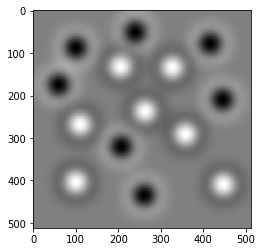

Min:  -0.31814464487021177
Max:  0.281373091264522


In [61]:
L_xx = img
L_xx = scipy.ndimage.convolve(L_xx, scd_gauss)
L_xx = scipy.ndimage.convolve(L_xx, gauss.transpose())

L_yy = img
L_yy = scipy.ndimage.convolve(L_yy, scd_gauss.transpose())
L_yy = scipy.ndimage.convolve(L_yy, gauss)

L_nab = L_xx + L_yy

# Show the filtered image:
plt.imshow(L_nab, cmap = "gray")
plt.show()
print("Min: ", min(map(lambda x: min(x), L_nab)))
print("Max: ", max(map(lambda x: max(x), L_nab)))

Note that the seperability of the gaussians are used to speed up computations.

### Task 4

We now compute local maxima/minima for the output image from the previous exercise using the scale $t$.

In [62]:
center_min = feature.peak_local_max(-L_nab, min_distance=1, threshold_rel=0.9)
center_max = feature.peak_local_max(L_nab, min_distance=1, threshold_rel=0.9)
print(center_min)

[[434 261]
 [320 207]
 [210 445]
 [175  60]
 [ 88 101]
 [ 78 416]
 [ 51 240]]


### Task 5

From the notes we have that the radius of the circles on the test-picture in an optimal setting should be equal to $\sqrt{2t}$. As we know the the radius, $r$, is $25$, this amounts to setting $t = \frac{25^2}{2}$. Doing this we have:

C:\Users\aabil\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


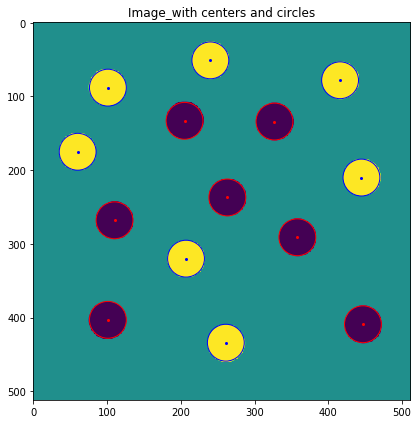

In [73]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)

im1 = ax.imshow(img, cmap='viridis')
ax.set_title('Image_with centers and circles')
ax.scatter(center_min[:,1], center_min[:,0], c='blue', s=4)
ax.scatter(center_max[:,1], center_max[:,0], c='red', s=4)
for iCirc in range(len(center_min[:,1])):
    circ = plt.Circle((center_min[iCirc,1], center_min[iCirc,0]), 25, edgecolor='blue', facecolor='None', fill=False)
    ax.add_artist(circ)
for iCirc in range(len(center_max[:,1])):
    circ = plt.Circle((center_max[iCirc,1], center_max[iCirc,0]), 25, edgecolor='red', facecolor='None', fill=False)
    ax.add_artist(circ)
fig.show()
fig.tight_layout()

### Task 6

Putting $t=25^2/2$ achieves the required result.

### Task 7

The scale invariant Laplacian is given as $t\nabla^2L$.

In [74]:
def scanScaleSpace(img, t_lst, s=3):
    r, c = img.shape
    L = np.zeros((len(t_lst),r,c))
    
    for i, t in enumerate(t_lst):
        scd_gauss = scd_deriv_gaussian(t, s) # Second dev. gaussian filter
        gauss = gaussian(t, s) # Gaussian filter
    
        L_xx = img
        L_xx = scipy.ndimage.convolve(L_xx, scd_gauss)
        L_xx = scipy.ndimage.convolve(L_xx, gauss.transpose())
    
        L_yy = img
        L_yy = scipy.ndimage.convolve(L_yy, scd_gauss.transpose())
        L_yy = scipy.ndimage.convolve(L_yy, gauss)
    
        L_nab = t*(L_xx + L_yy)
        
        L[i,:,:] = L_nab
        
    return L

In [75]:
min_size = 5
max_size = 40
sizes = np.arange(min_size, max_size)
t_lst = sizes**2/2

scale_space_L = scanScaleSpace(img, t_lst)

In [81]:
print(sizes)

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39]


In [76]:
center_min = feature.peak_local_max(-scale_space_L, min_distance=1, threshold_rel=0.9)
center_max = feature.peak_local_max(scale_space_L, min_distance=1, threshold_rel=0.9)
    
center_min_2d = center_min[:,1:]
center_max_2d = center_max[:,1:]

print(center_min)
print(center_max)

[[ 21 434 261]
 [ 21 320 207]
 [ 21 210 445]
 [ 21 175  60]
 [ 21  88 101]
 [ 21  78 416]
 [ 21  51 240]
 [ 19 434 261]
 [ 19 320 207]
 [ 19 210 445]
 [ 19 175  60]
 [ 19  88 101]
 [ 19  78 416]
 [ 19  51 240]]
[[ 20 409 447]
 [ 20 403 101]
 [ 20 291 358]
 [ 20 268 110]
 [ 20 237 263]
 [ 20 134 327]
 [ 20 133 205]]


As seen above the detected scales are:


In [77]:
print("Detected scales: ", sizes[19], ", ", sizes[20], ", ", sizes[21])

Detected scales:  24 ,  25 ,  26


C:\Users\aabil\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


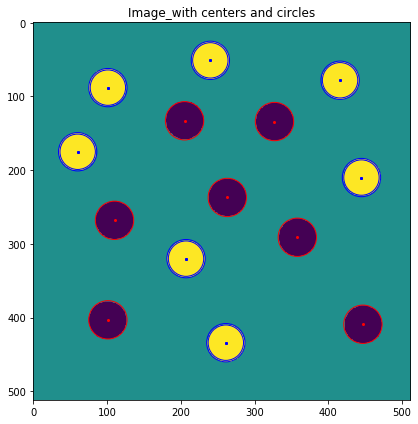

In [83]:
# We plot the points from all detected scales:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)

im1 = ax.imshow(img, cmap='viridis')
ax.set_title('Image_with centers and circles')
ax.scatter(center_min_2d[:,1], center_min_2d[:,0], c='blue', s=4)
ax.scatter(center_max_2d[:,1], center_max_2d[:,0], c='red', s=4)
for iCirc in range(len(center_min_2d[:,1])):
    circ = plt.Circle((center_min_2d[iCirc,1], center_min_2d[iCirc,0]), sizes[center_min[iCirc,0]], edgecolor='blue', facecolor='None', fill=False)
    ax.add_artist(circ)
for iCirc in range(len(center_max_2d[:,1])):
    circ = plt.Circle((center_max_2d[iCirc,1], center_max_2d[iCirc,0]), sizes[center_max[iCirc,0]], edgecolor='red', facecolor='None', fill=False)
    ax.add_artist(circ)
fig.show()
fig.tight_layout()

### Task 8

We now detect blobs in the test image test_blob_varying.png.

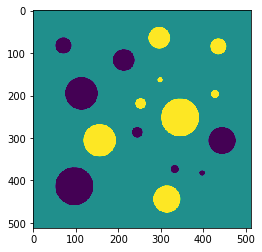

In [84]:
img = cv2.imread('EX_2_data/test_blob_varying.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(float)
plt.imshow(img)
plt.show()

In [85]:
min_size = 5
max_size = 50
sizes = np.arange(min_size, max_size)
t_lst = sizes**2/2

scale_space_L = scanScaleSpace(img, t_lst)

center_min = feature.peak_local_max(-scale_space_L, min_distance=1, threshold_rel=0.9)
center_max = feature.peak_local_max(scale_space_L, min_distance=1, threshold_rel=0.9)

center_min_2d = center_min[:,1:]
center_max_2d = center_max[:,1:]

In [86]:
print(center_min)

[[ 41 253 347]
 [ 36 306 156]
 [ 27 443 314]
 [ 21  65 296]
 [ 19  65 296]
 [ 14  85 435]
 [  8 219 252]
 [  5 197 427]
 [  1 163 298]]


5
6
7
8
9
10
11
12
13
5
6
7
8
9
10
11
12
13


C:\Users\aabil\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


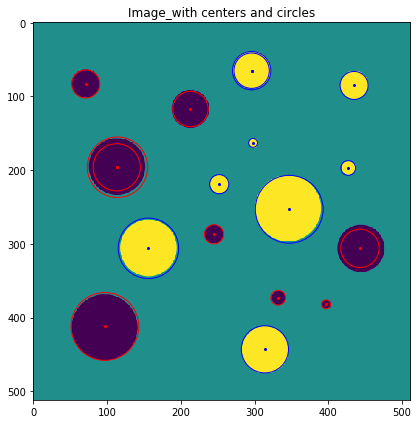

In [87]:
# We plot the points from all detected scales:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)

im1 = ax.imshow(img, cmap='viridis')
ax.set_title('Image_with centers and circles')
ax.scatter(center_min_2d[:,1], center_min_2d[:,0], c='blue', s=4)
ax.scatter(center_max_2d[:,1], center_max_2d[:,0], c='red', s=4)
for iCirc in range(len(center_min_2d[:,1])):
    print(sizes[iCirc])
    circ = plt.Circle((center_min_2d[iCirc,1], center_min_2d[iCirc,0]), sizes[center_min[iCirc,0]], edgecolor='blue', facecolor='None', fill=False)
    ax.add_artist(circ)
for iCirc in range(len(center_max_2d[:,1])):
    print(sizes[iCirc])
    circ = plt.Circle((center_max_2d[iCirc,1], center_max_2d[iCirc,0]), sizes[center_max[iCirc,0]], edgecolor='red', facecolor='None', fill=False)
    ax.add_artist(circ)
fig.show()
fig.tight_layout()

### Task 9

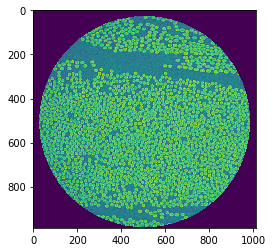

In [182]:
img = cv2.imread('EX_2_data/CT_lab_high_res.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(float)
plt.imshow(img)
plt.show()

In [40]:
img.shape

(600, 600)

In [183]:
#min_size = 2
#max_size = 12

min_size = 1
max_size = 12
sizes = np.arange(min_size, max_size)
t_lst = sizes**2/2

scale_space_L = scanScaleSpace(img, t_lst)

#enter_min = feature.peak_local_max(-scale_space_L, min_distance=1, threshold_rel=0.25)
#center_max = feature.peak_local_max(scale_space_L, min_distance=1, threshold_rel=0.25)

center_min = feature.peak_local_max(-scale_space_L, min_distance=1, threshold_rel=0.3)
center_max = feature.peak_local_max(scale_space_L, min_distance=1, threshold_rel=0.3)

center_min_2d = center_min[:,1:]
center_max_2d = center_max[:,1:]


In [185]:
print(center_min)
print(center_max)
print("max size: ", sizes[max(center_max[:,0])])
print("max size: ", sizes[max(center_min[:,0])])
print("min size: ", sizes[min(center_min[:,0])])
print("min size: ", sizes[min(center_max[:,0])])

[[  9 971 538]
 [  9 939 586]
 [  9 882 787]
 ...
 [  1  31 457]
 [  1  30 551]
 [  1  30 462]]
[[  9 910 593]
 [  9 899 558]
 [  9 868 684]
 ...
 [  1  39 522]
 [  1  38 581]
 [  1  33 535]]
max size:  10
max size:  10
min size:  2
min size:  2


C:\Users\aabil\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


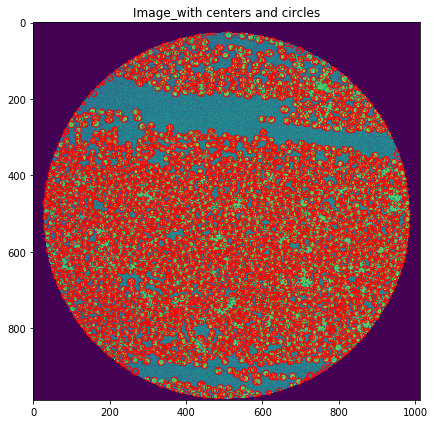

In [186]:
# We plot the points from all detected scales:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)

im1 = ax.imshow(img, cmap='viridis')
ax.set_title('Image_with centers and circles')
#ax.scatter(center_min_2d[:,1], center_min_2d[:,0], c='red', s=4)
#ax.scatter(center_max_2d[:,1], center_max_2d[:,0], c='red', s=4)
for iCirc in range(len(center_min_2d[:,1])):
    circ = plt.Circle((center_min_2d[iCirc,1], center_min_2d[iCirc,0]), sizes[center_min[iCirc,0]], edgecolor='red', facecolor='None', fill=False)
    ax.add_artist(circ)
#for iCirc in range(len(center_max_2d[:,1])):
#    circ = plt.Circle((center_max_2d[iCirc,1], center_max_2d[iCirc,0]), sizes[center_max[iCirc,0]], edgecolor='red', facecolor='None', fill=False)
#    ax.add_artist(circ)
fig.show()
fig.tight_layout()